###This notebook:
+ EFFECT OF PRE-PROCESING OF DATA
+ ktrain
+ hugging face transformers
+ distilroberta-base / roberta-base
+ LR == 5e-5
+ LR policy: autofit (triangle)
+ WITH pre-processing of texts
+ lower maxlen

###Check requirements/Imports

In [ ]:
! python --version

Python 3.7.10


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import os

import numpy as np
import pandas as pd

from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
!pip3 install ktrain

In [ ]:
pip install contractions

In [ ]:
pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##Data part

###Load training data

In [ ]:
# Load train data
train_path = '/content/drive/MyDrive/TeamLab/data/corrected_isear-train.csv'

df_train = pd.read_csv(train_path, names=['emotion', 'text', 'NaN'])                          

In [ ]:
df_train.head()

,emotion,text,NaN
0,joy,When I understood that I was admitted to the U...,NaN
1,fear,I broke a window of a neighbouring house and I...,NaN
2,joy,Got a big fish in fishing.,NaN
3,fear,"Whenever I am alone in a dark room, walk alone...",NaN
4,shame,I bought a possible answer to a homework probl...,NaN


In [ ]:
classes = df_train.emotion.unique()
classes

array(['joy', 'fear', 'shame', 'disgust', 'guilt', 'anger', 'sadness'],
      dtype=object)

In [ ]:
# Check if dataset is balanced

for emo in classes:
    n_instances = (df_train.emotion == emo).sum()
    print(emo, "class has", n_instances, "instances")

# => Balanced

joy class has 779 instances
fear class has 758 instances
shame class has 762 instances
disgust class has 762 instances
guilt class has 770 instances
anger class has 758 instances
sadness class has 768 instances


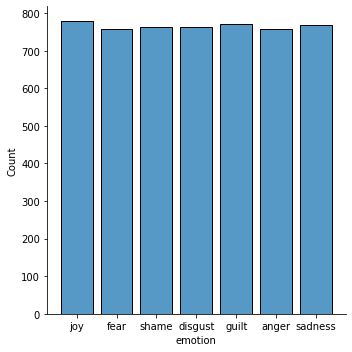

In [ ]:
import seaborn as sns

sns.displot(df_train, x="emotion", shrink=.8)

###Load validation data

In [ ]:
# Load validation data
val_path = '/content/drive/MyDrive/TeamLab/data/corrected_isear-val.csv'

df_val = pd.read_csv(val_path, names=['emotion', 'text', 'NaN'])

df_val.head()

,emotion,text,NaN
0,joy,"On holiday, seeing the lanscape in Gerona.",NaN
1,guilt,When one of my parents insinuates something ab...,NaN
2,sadness,When I am alone and listen to a song which I l...,NaN
3,joy,I'd just got the top mark in an exam.,NaN
4,shame,"I remember that once, a friend did not co-oper...",NaN


###Load test data

In [ ]:
# Load test data
test_path = '/content/drive/MyDrive/TeamLab/data/corrected_isear-test.csv'

df_test = pd.read_csv(test_path, names=['emotion', 'text', 'NaN'])

df_test.head()

,emotion,text,NaN
0,anger,Deliberately provoked by someone close. Angere...,NaN
1,shame,In my 20s - and was going out to dinner to cel...,NaN
2,guilt,When I noticed that my little sister was sulki...,NaN
3,disgust,I got disgusted with a man who was beating a w...,NaN
4,joy,When I passed the driving test (on the second ...,NaN


In [ ]:
x_train = df_train['text'].to_numpy()
y_train = df_train['emotion'].to_numpy()

x_val = df_val['text'].to_numpy()
y_val = df_val['emotion'].to_numpy()

x_test = df_test['text'].to_numpy()
y_test = df_test['emotion'].to_numpy()

print(x_train[0])
print(y_train[0])

When I understood that I was admitted to the University.
joy


###Normalise input

In [ ]:
import re
import contractions
import nltk


def normalise_text(text):

    # Expand contractions
    norm_text = contractions.fix(text)

    # Remove stop words
    stop_words = ['and', 'the', 'to', 'a', 'an', 'of', 'or']
    nostops = []
    for word in nltk.word_tokenize(norm_text):
        if word.lower() not in stop_words:
            # lowercase
            nostops.append(word)
    norm_text = ' '.join(nostops)

    # Remove punctuation
    norm_text = re.sub(r"[-()#/@;:<>{}=~\.\?\"\[\]]+", "", norm_text)


    return norm_text

In [ ]:
x_train_norm = []
for text in x_train:
    x_train_norm.append(normalise_text(text))


# Normalise val and test too??
x_val_norm = []
for text in x_val:
    x_val_norm.append(normalise_text(text))

x_test_norm = []
for text in x_test:
    x_test_norm.append(normalise_text(text))

x_train_norm = np.array(x_train_norm)
x_val_norm = np.array(x_val_norm)
x_test_norm = np.array(x_test_norm)

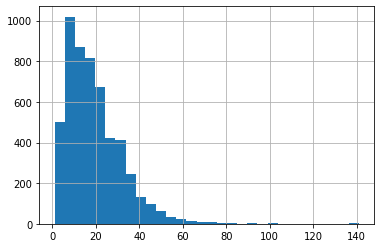

In [ ]:
# get length of all the texts in the train set
seq_len = [len(i.split()) for i in x_train_norm]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
from statistics import mean

print(max(seq_len))
print(mean(seq_len))

141
19.05656150830689


In [ ]:
seq_len = []

idx = 0
for text in x_train_norm:
    if len(text.split()) > 75:
        print(idx, text)
    seq_len.append(len(text.split()))
    idx += 1

# some sentences are v long (:

111 It was week before higher level results were announced  I had tried failed many times this was last time that I was taking exam  I knew that if i failed again I woulld have enter society  I imagined things during this period  I dreamt that I had entered university it was nice experience  When I thought about future , unexplainable fear rose in me  I feared being worker not having bright prospect , I also feared criticism my relatives as my brother had gone university  Whenevr I thought this issue I could not eat concentrate , my heart beat increased 
654 When I still went primaryschool , I went on skitrip with my family  After skiing we went restaurant for lunch  Suddenly my father said that he had forgotten something in car  He gave me key asked me go get it  I had difficulties with key which was already bent  I asked my mother help me  When she tried turn key it broke  We had no second key  My mother was blamed for all that I did not say word 
763 When my grandmother died  I was 

##Model

###Set up

In [ ]:
import ktrain
from ktrain import text

categories = ['joy', 'fear', 'shame', 'disgust', 'guilt', 'anger', 'sadness']

MODEL_NAME = 'roberta-base'

# Transormer is a wrapper to the Hugging Face transformers library for text classification.
# maxlen=??
t = text.Transformer(MODEL_NAME, maxlen=150, class_names=categories)

# input data
trn = t.preprocess_train(x_train_norm, y_train)
val = t.preprocess_test(x_val_norm, y_val)

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)


preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 42
	99percentile : 61


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:600: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 67


###Estimate learning rate

In [ ]:
# Estimate good learning rate

# set max_epochs or this will take hours to run (default epochs == 1024!!)
learner.lr_find(max_epochs=2)
learner.lr_plot()

###Train

In [ ]:
# the maximal learning rate associated with a still falling loss is a good choice for training
best_lr = 5e-5

In [ ]:
# Train
# Parameters: LR, epochs

# Learning policies: 
# triangular LR -> learner.autofit(0.0007, 8) (implicit ReduceLROnPlateau and EarlyStopping)
# 1cycle -> learner.fit_onecycle(best_lr, 5)

#learner.autofit(best_lr, 10, early_stopping=True)

learner.autofit(lr=best_lr, checkpoint_folder='/my_models', verbose=1)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
335/335 [==============================] - 197s 546ms/step - loss: 1.2641 - accuracy: 0.5268 - val_loss: 0.8919 - val_accuracy: 0.6916
Epoch 2/1024
335/335 [==============================] - 183s 543ms/step - loss: 0.7996 - accuracy: 0.7269 - val_loss: 0.8707 - val_accuracy: 0.7082
Epoch 3/1024
335/335 [==============================] - 183s 544ms/step - loss: 0.6389 - accuracy: 0.7855 - val_loss: 0.9246 - val_accuracy: 0.7073
Epoch 4/1024
335/335 [==============================] - 183s 544ms/step - loss: 0.5022 - accuracy: 0.8294 - val_loss: 0.9239 - val_accuracy: 0.7064

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 5/1024
335/335 [==============================] - 183s 544ms/step - loss: 0.3374 - accuracy: 0.8856 - val_loss: 1.0063 - val

###Evaluate/Inspect model

In [ ]:
#72 accuracy in the last epoch? loss too high, model did not save weights
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

       anger       0.67      0.59      0.63       160
     disgust       0.62      0.72      0.66       159
        fear       0.75      0.78      0.76       171
       guilt       0.64      0.68      0.66       165
         joy       0.84      0.93      0.88       151
     sadness       0.79      0.70      0.74       175
       shame       0.66      0.58      0.62       167

    accuracy                           0.71      1148
   macro avg       0.71      0.71      0.71      1148
weighted avg       0.71      0.71      0.71      1148



array([[ 95,  34,   7,  12,   1,   6,   5],
       [ 16, 114,   9,   5,   4,   5,   6],
       [  3,   9, 133,  11,   6,   5,   4],
       [  6,   7,   9, 112,   3,   6,  22],
       [  1,   0,   3,   1, 140,   5,   1],
       [ 13,   6,   8,   5,   8, 122,  13],
       [  8,  14,   9,  28,   5,   6,  97]])

In [ ]:
# Set weights to those of the best epoch
learner.model.load_weights('/my_models/weights-07.hdf5')

In [ ]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

       anger       0.67      0.59      0.63       160
     disgust       0.62      0.72      0.66       159
        fear       0.75      0.78      0.76       171
       guilt       0.64      0.68      0.66       165
         joy       0.84      0.93      0.88       151
     sadness       0.79      0.70      0.74       175
       shame       0.66      0.58      0.62       167

    accuracy                           0.71      1148
   macro avg       0.71      0.71      0.71      1148
weighted avg       0.71      0.71      0.71      1148



array([[ 95,  34,   7,  12,   1,   6,   5],
       [ 16, 114,   9,   5,   4,   5,   6],
       [  3,   9, 133,  11,   6,   5,   4],
       [  6,   7,   9, 112,   3,   6,  22],
       [  1,   0,   3,   1, 140,   5,   1],
       [ 13,   6,   8,   5,   8, 122,  13],
       [  8,  14,   9,  28,   5,   6,  97]])

In [ ]:
# the ones that we got most wrong
learner.view_top_losses(n=10, preproc=t)

----------
id:685 | loss:5.81 | true:anger | pred:fear)

----------
id:107 | loss:5.8 | true:guilt | pred:fear)

----------
id:581 | loss:5.63 | true:disgust | pred:guilt)

----------
id:901 | loss:5.6 | true:guilt | pred:fear)

----------
id:456 | loss:5.47 | true:disgust | pred:joy)

----------
id:686 | loss:5.46 | true:anger | pred:sadness)

----------
id:1038 | loss:5.31 | true:sadness | pred:joy)

----------
id:1135 | loss:5.23 | true:shame | pred:fear)

----------
id:893 | loss:5.16 | true:fear | pred:disgust)

----------
id:707 | loss:5.04 | true:fear | pred:guilt)



In [ ]:
# print out instance to see why...
print(x_test_norm[685])
print(x_test_norm[107])
print(x_test_norm[581])
print(x_test_norm[901])
print(x_test_norm[456])

print(x_test_norm[686])
print(x_test_norm[1038])
print(x_test_norm[1135])
print(x_test_norm[893])
print(x_test_norm[707])

I was involved in  attempt on man I had developed close warming relationship with  Although I knew I had done everything I could that his progress `` normal '' life was poor I felt guilty as if I could have done more 
My parents put pressure on me buy clothes , when I would not have liked do so 
I got back too late after Sunday going out without having called up home tell where I was  my mother had not slept whole night 
I tried my level best care for my client , I took appointment with doctor before meeting doctor he expired  poor small boy from Uttar Pradesh 
When I was 13 years old I wrote passionate love letters my boyfriend I later found out that his sister had read them 
When I was 8 years old my tonsils had be operated on  This is not complicated operation , but just before it started I was very afraid so that I will never forget it 
Late one night I was pursued by gipsies who had no good intentions 
When I was told friend 's baby had been born with only partial sight  This was 

###Make predictions on new data

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
test_sent = ('Even though it is raining, it is a nice day and I do not feel sad')

In [ ]:
predictor.predict(test_sent)

'sadness'

In [ ]:
# Ask for explanation
predictor.explain(test_sent)

nice and not did not weigh the class sadness down???


In [ ]:
more_sents = ['Playing with a very cute doggo', 
              'Feeling lonely', 
              'I rode at the back of a scooter driven by a stranger on the motorway in Vietnam, not knowing where we were going', 
              'I told my mum a lie and it caused her being very disappointed afterwards', 
              'I shat myself at school', 
              'when I see dirty houses full of useless crap',
              'seeing racist and homophobic comments infuriates me']

In [ ]:
predictor.predict(more_sents)

['joy', 'sadness', 'fear', 'guilt', 'shame', 'disgust', 'disgust']

In [ ]:
# Ask for explanation
predictor.explain(more_sents[0])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[0])

array([0.02922391, 0.15155779, 0.05300738, 0.03570715, 0.59231126,
       0.00992   , 0.12827246], dtype=float32)

it did not recognise that doggo mean the same as dog? or else why would 'dog' not point to joy? maybe mentioned in dataset together with negative emotions

In [ ]:
# Ask for explanation
predictor.explain(more_sents[1])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[1])

array([0.01033659, 0.00399974, 0.03788786, 0.01552091, 0.00734928,
       0.91757435, 0.00733132], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[2])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[2])

array([0.00301724, 0.00442291, 0.9773337 , 0.00285233, 0.00268387,
       0.00481793, 0.00487193], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[3])

intended label was guilt, but shame and guilt seem to be very hard to distinguish. people seem to have very confused definitions about these 2 emotions. P almost 50/50

shame in oneself == guilt?

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[3])

array([0.009305  , 0.00533283, 0.00716193, 0.5693099 , 0.00630033,
       0.01158988, 0.3910001 ], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[4])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[4])

array([0.00933028, 0.01355776, 0.00525677, 0.16029231, 0.00463122,
       0.0058877 , 0.801044  ], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[5])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[5])

array([0.03695761, 0.9332121 , 0.00426531, 0.00323279, 0.00174926,
       0.01250011, 0.00808276], dtype=float32)

dirty must have had a lot of weight

In [ ]:
# Ask for explanation
predictor.explain(more_sents[6])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[6])

array([0.10566305, 0.8485837 , 0.00561718, 0.00526324, 0.00176676,
       0.01731081, 0.01579522], dtype=float32)

###Save + Reload

In [ ]:
predictor.save('/my_models/EC_RoBERTa_norm')

In [ ]:
# Reload to check that model has been saved correctly
reloaded_predictor = ktrain.load_predictor('/my_models/EC_RoBERTa_norm')

In [ ]:
reloaded_predictor.predict(test_sent)

'sadness'

In [ ]:
# Do reloaded_predictor and original predictor give the same numbers?
reloaded_predictor.predict_proba(test_sent)

array([0.00651337, 0.00358102, 0.01465594, 0.01220149, 0.02344772,
       0.9361761 , 0.00342437], dtype=float32)

In [ ]:
predictor.predict_proba(test_sent)

array([0.00651337, 0.00358102, 0.01465594, 0.01220149, 0.02344772,
       0.9361761 , 0.00342437], dtype=float32)

In [ ]:
reloaded_predictor.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

**!!!before running next cell:**
+ keep only best weight and put it into model folder
+ move my_models into 'content' 

In [ ]:
# Copy model files to drive - files on google colab disk space are temporary and get deleted when the session is over

%cp -av "/content/my_models/EC_RoBERTa_norm" "/content/drive/MyDrive/TeamLab/my_models"

'/content/my_models/EC_RoBERTa_norm' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_norm'
'/content/my_models/EC_RoBERTa_norm/config.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_norm/config.json'
'/content/my_models/EC_RoBERTa_norm/tf_model.h5' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_norm/tf_model.h5'
'/content/my_models/EC_RoBERTa_norm/tokenizer_config.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_norm/tokenizer_config.json'
'/content/my_models/EC_RoBERTa_norm/special_tokens_map.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_norm/special_tokens_map.json'
'/content/my_models/EC_RoBERTa_norm/vocab.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_norm/vocab.json'
'/content/my_models/EC_RoBERTa_norm/merges.txt' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_norm/merges.txt'
'/content/my_models/EC_RoBERTa_norm/tf_model.preproc' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_norm/tf_model


To load and continue training
```
# save model and Preprocessor instance after partially training
ktrain.get_predictor(model, preproc).save('/tmp/my_predictor')

# reload Predictor and extract model
model = ktrain.load_predictor('/tmp/my_predictor').model

# re-instantiate Learner and continue training
learner = ktrain.get_learner(model, train_data=trn, val_data=val)
learner.fit_onecycle(2e-5, 1)
```

